# **Cтандартный алгоритм Метрополиса-Гастингса**

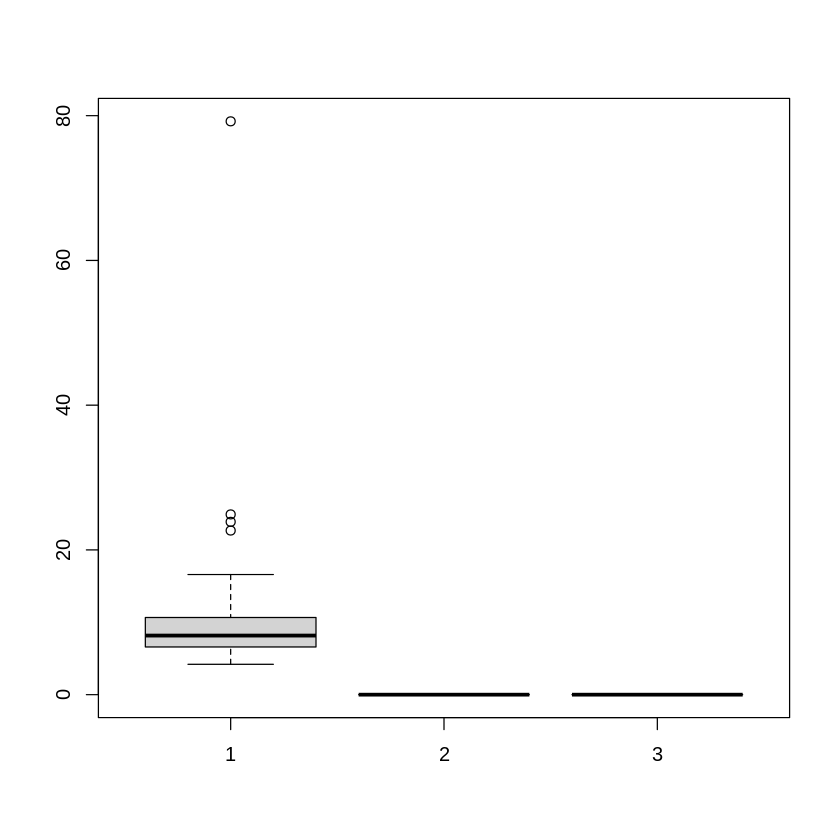

In [ ]:
library("MASS")

d = 2
r = 3
n = 500
M = 100

E = rep(0,M)
W = matrix(0,M,3)
V<-c(rep(1, 1+d+d*r), rep(1, 1+r+1+r))*diag(1+d+d*r+2+2*r)


#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

t = 1

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}


for (N in c(500)){
  for(m in 1:M){

    X = matrix(rnorm(d*n),n,d)
    #Параметры
    w_0 = rnorm(1, mu_w_0, sqrt(1/lambda_w_0))
    lambda_w = rgamma(1, shape = alpha_lambda, rate = beta_lambda)
    mu_w = rnorm(1, mu_0, sqrt(1/(gamma_0*lambda_w)))
    w = rnorm(d, mu_w, sqrt(1/lambda_w))
    lambda_v = rgamma(r, shape = alpha_lambda, rate = beta_lambda)
    mu_v = rnorm(r, mu_0, sqrt(1/(gamma_0*lambda_v)))
    v = matrix(rnorm((d*r), mu_v, sqrt(1/lambda_v)),d,r,byrow=TRUE)

    #Beta_teor
    Beta_teor = c(w_0, w, c(t(v)), mu_w, mu_v, lambda_w, lambda_v)

    doudle_Sum_teor1 = 0.5 * rowSums((X%*%v)^2 - (X^2)%*%(v^2))
    p = 1 /(1 + exp(-(w_0 + X %*%w + doudle_Sum_teor1)))
    y = rbinom(n,1,p)

    mu_w_new = 0
    mu_v_new = rep(0, r)
    lambda_w_new = 1
    lambda_v_new = rep(1, r)

    Theta_0 = 0
    Theta_w = rep(0, d)
    Theta_v = rep(0, d*r)
    Beta = c(Theta_0, Theta_w, Theta_v, mu_w_new, mu_v_new, lambda_w_new, lambda_v_new)

    Theta_v_matrix = t(matrix(Theta_v, r, d))

    SaveResults<- matrix(0,N,1+d+d*r+2+2*r)

    #Логарифм функции правдоподобия для Beta
    loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
    #Логарифм априорного распределения для Theta_H для Beta
    log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
    #Логарифм априорного распределения для Theta для Beta
    log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

    #Логарифм апостериорного распределения для Beta
    logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

    for(i in 1:N){
      Beta_new <- mvrnorm(1, Beta, V) # надо правильно подбирать матрицу V

      Beta_Theta_0 = Beta_new[1]
      Beta_Theta_w = Beta_new[2:(d+1)]
      Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
      Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

      Beta_mu_w_new = Beta_new[1+d+d*r+1]
      Beta_mu_v_new = Beta_new[(1+d+d*r+2):(1+d+d*r+1+r)]

      Beta_lambda_w_new = Beta_new[1+d+d*r+2+r]
      Beta_lambda_v_new = Beta_new[(1+d+d*r+3+r):(1+d+d*r+2+2*r)]

      if (Beta_lambda_w_new < 0 | any(Beta_lambda_v_new < rep(0,r))){
        SaveResults[i,] <- Beta
        next
      }

      #Логарифм функции правдоподобия для Beta_new
      loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
      #Логарифм априорного распределения для Theta_H для Beta_new
      log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
      #Логарифм априорного распределения для Theta для Beta_new
      log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

      #Логарифм апостериорного распределения для Beta_new
      logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

      alpha = logpost_Beta_new - logpost_Beta

      if(log(runif(1)) <  alpha)
      {
        Beta <- Beta_new
        logpost_Beta <- logpost_Beta_new
      }
       SaveResults[i,] <- Beta
    }
    b_1 <- colMeans(SaveResults)
    E[m] = sqrt(sum((Beta_teor - b_1)^2))
  }
  W[,t] = E
  t = t+1
}
boxplot(W)


# **Cтандартный алгоритм Метрополиса-Гастингса (небольшая размерность)**

0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.000000,0.000000,0.0000000,0.000000,1.000000,1.00000000,1.000000
0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.000000,0.000000,0.0000000,0.000000,1.000000,1.00000000,1.000000
0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.000000,0.000000,0.0000000,0.000000,1.000000,1.00000000,1.000000
0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.000000,0.000000,0.0000000,0.000000,1.000000,1.00000000,1.000000
0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.000000,0.000000,0.0000000,0.000000,1.000000,1.00000000,1.000000
0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.000000,0.000000,0.0000000,0.000000,1.000000,1.00000000,1.000000
0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.000000,0.000000,0.0000000,0.000000,1.000000,1.00000000,1.000000
0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.000000,0.000000,0.0000000,0.000000,1.000000,1.00000000,1.000000
0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.000000,0.000000,0.0000000,0.000000,1.000000,1.00000000,1.000000
0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.000000,0.000000,0.0000000,0.000000,1.000000,1.00000000,1.000000
0.0000000,0.0000000,0.000000,0.0000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.000000,0.000000,0.0000000,0.000000,1.000000,1.00000000,1.000000


Среднее по матрице 0.3664439 -0.3276228 -0.5370404 -0.1584135 -0.2586583 -0.09828268 0.1630159 -0.1110625 0.04120554 0.5109811 0.7866625 -0.3446502 0.4399318 1.411332 0.6700115 1.410592 


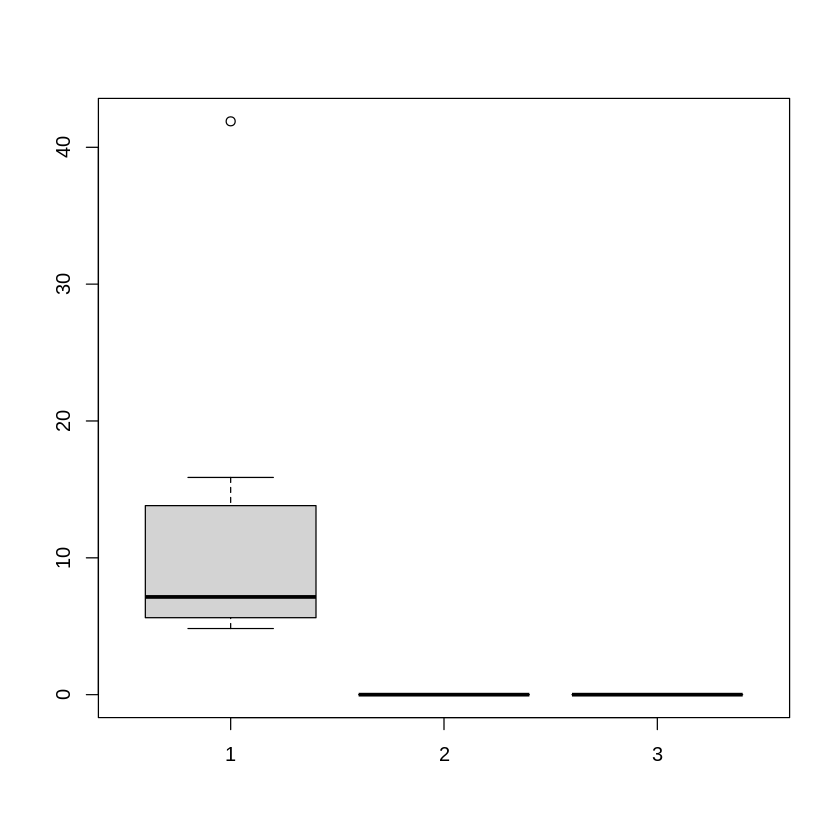

In [ ]:
library("MASS")

d = 3
r = 2
n = 500
M = 10

E = rep(0,M)
W = matrix(0,M,3)
V<-c(rep(1, 1+d+d*r), rep(1, 1+r+1+r))*diag(1+d+d*r+2+2*r)


#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

t = 1

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}


for (N in c(50)){
  for(m in 1:M){

    X = matrix(rnorm(d*n),n,d)
    #Параметры
    w_0 = rnorm(1, mu_w_0, sqrt(1/lambda_w_0))
    lambda_w = rgamma(1, shape = alpha_lambda, rate = beta_lambda)
    mu_w = rnorm(1, mu_0, sqrt(1/(gamma_0*lambda_w)))
    w = rnorm(d, mu_w, sqrt(1/lambda_w))
    lambda_v = rgamma(r, shape = alpha_lambda, rate = beta_lambda)
    mu_v = rnorm(r, mu_0, sqrt(1/(gamma_0*lambda_v)))
    v = matrix(rnorm((d*r), mu_v, sqrt(1/lambda_v)),d,r,byrow=TRUE)

    #Beta_teor
    Beta_teor = c(w_0, w, c(t(v)), mu_w, mu_v, lambda_w, lambda_v)

    doudle_Sum_teor1 = 0.5 * rowSums((X%*%v)^2 - (X^2)%*%(v^2))
    p = 1 /(1 + exp(-(w_0 + X %*%w + doudle_Sum_teor1)))
    y = rbinom(n,1,p)

    mu_w_new = 0
    mu_v_new = rep(0, r)
    lambda_w_new = 1
    lambda_v_new = rep(1, r)

    Theta_0 = 0
    Theta_w = rep(0, d)
    Theta_v = rep(0, d*r)
    Beta = c(Theta_0, Theta_w, Theta_v, mu_w_new, mu_v_new, lambda_w_new, lambda_v_new)

    Theta_v_matrix = t(matrix(Theta_v, r, d))

    SaveResults<- matrix(0,N,1+d+d*r+2+2*r)

    #Логарифм функции правдоподобия для Beta
    loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
    #Логарифм априорного распределения для Theta_H для Beta
    log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
    #Логарифм априорного распределения для Theta для Beta
    log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

    #Логарифм апостериорного распределения для Beta
    logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

    for(i in 1:N){
      Beta_new <- mvrnorm(1, Beta, V) # надо правильно подбирать матрицу V
      Beta_Theta_0 = Beta_new[1]
      Beta_Theta_w = Beta_new[2:(d+1)]
      Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
      Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

      Beta_mu_w_new = Beta_new[1+d+d*r+1]
      Beta_mu_v_new = Beta_new[(1+d+d*r+2):(1+d+d*r+1+r)]

      Beta_lambda_w_new = Beta_new[1+d+d*r+2+r]
      Beta_lambda_v_new = Beta_new[(1+d+d*r+3+r):(1+d+d*r+2+2*r)]

      if (Beta_lambda_w_new < 0 | any(Beta_lambda_v_new < rep(0,r))){
        SaveResults[i,] <- Beta
        next
      }

      #Логарифм функции правдоподобия для Beta_new
      loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
      #Логарифм априорного распределения для Theta_H для Beta_new
      log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
      #Логарифм априорного распределения для Theta для Beta_new
      log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

      #Логарифм апостериорного распределения для Beta_new
      logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

      alpha = logpost_Beta_new - logpost_Beta

      if(log(runif(1)) <  alpha)
      {
        Beta <- Beta_new
        logpost_Beta <- logpost_Beta_new
      }
       SaveResults[i,] <- Beta
    }
    b_1 <- colMeans(SaveResults)
    E[m] = sqrt(sum((Beta_teor - b_1)^2))
  }
  W[,t] = E
  t = t+1
}
SaveResults
cat("Среднее по матрице", b_1, "\n")
boxplot(W)

# **Datasets**

In [ ]:
install.packages("PRROC")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



**Pima Indians Diabetes Dataset**

[1] 0.5

ERROR: Error in image.default(c(1), scale, matrix(scale, nrow = 1), col = cols, : increasing 'x' and 'y' values expected


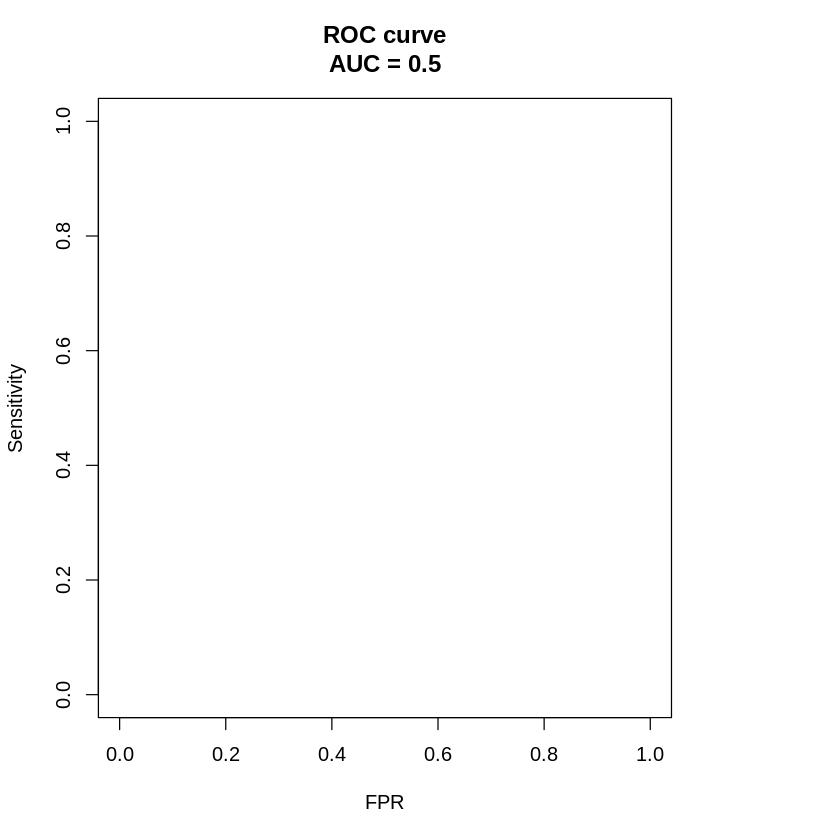

In [ ]:
library("MASS")
library("PRROC")
library(data.table)

data <- fread("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv", header=TRUE)
data = as.matrix(data)

X = data[1:500,1:8]
y = data[1:500,9]

d = ncol(X)
n = 500
r = 3
N = 100

V<-c(rep(1, 1+d+d*r), rep(1, 1+r+1+r))*diag(1+d+d*r+2+2*r)
SaveResults<- matrix(0,N,1+d+d*r+2+2*r)

# Оптимальное значение prop из текста
lambda <- 2.38
opt_prop <- (lambda^2 / (1+d+d*r+2+2*r)) * V

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_w_new = 1
lambda_v_new = rep(1, r)

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

Theta_v_matrix = t(matrix(Theta_v, r, d))

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

#Логарифм функции правдоподобия для Beta
loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
#Логарифм априорного распределения для Theta_H для Beta
log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
#Логарифм априорного распределения для Theta для Beta
log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

#Логарифм апостериорного распределения для Beta
logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

for(i in 1:N){
  Beta_new <- mvrnorm(1, Beta, opt_prop) # надо правильно подбирать матрицу V
  Beta_Theta_0 = Beta_new[1]
  Beta_Theta_w = Beta_new[2:(d+1)]
  Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]

  Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

  Beta_mu_w_new = Beta_new[1+d+d*r+1]
  Beta_mu_v_new = Beta_new[(1+d+d*r+2):(1+d+d*r+1+r)]

  Beta_lambda_w_new = Beta_new[1+d+d*r+2+r]
  Beta_lambda_v_new = Beta_new[(1+d+d*r+3+r):(1+d+d*r+2+2*r)]

  if (Beta_lambda_w_new < 0 | any(Beta_lambda_v_new < rep(0,r))){
    SaveResults[i,] <- Beta
    next
  }

  #Логарифм функции правдоподобия для Beta_new
  loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
  #Логарифм априорного распределения для Theta_H для Beta_new
  log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
  #Логарифм априорного распределения для Theta для Beta_new
  log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

  #Логарифм апостериорного распределения для Beta_new
  logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

  alpha = logpost_Beta_new - logpost_Beta

  if(log(runif(1)) <  alpha)
  {
    Beta <- Beta_new
    logpost_Beta <- logpost_Beta_new
  }
    SaveResults[i,] <- Beta
}
b_1 <- colMeans(SaveResults)
V = matrix(b_1[(d+2):(d+1+d*r)],d,r,byrow=TRUE)

X1 = data[501:767,1:8]
y1 = data[501:767,9]
D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(b_1[1] + X1 %*%b_1[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Sonar Dataset**

[1] 0.5

ERROR: Error in image.default(c(1), scale, matrix(scale, nrow = 1), col = cols, : increasing 'x' and 'y' values expected


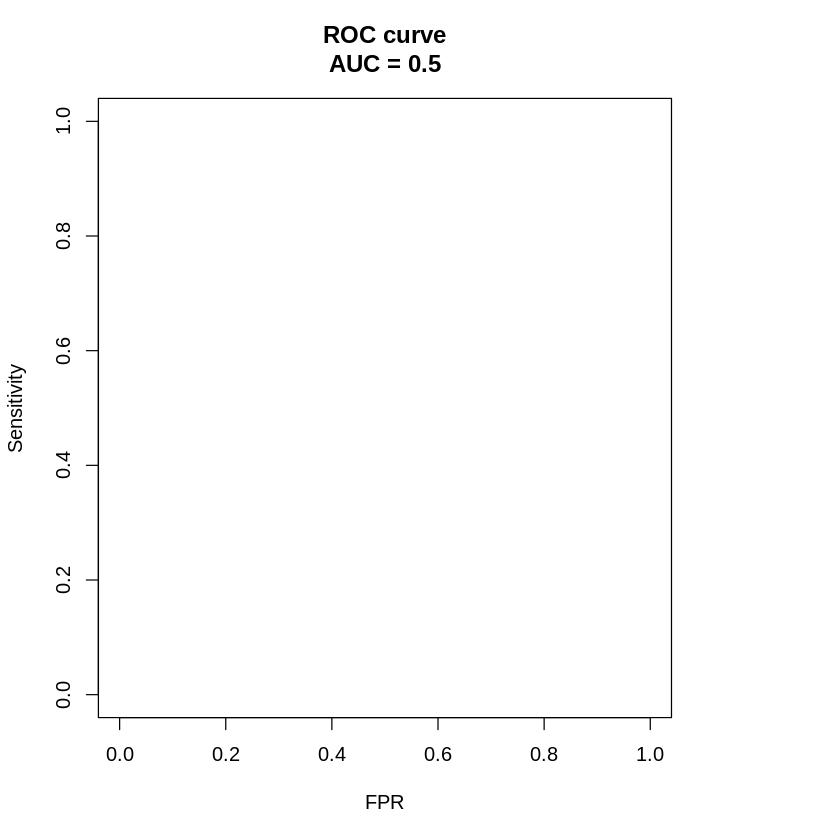

In [ ]:
library("MASS")
library("PRROC")
library(data.table)

data = fread("https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data", header=TRUE)
ind = sample(1:207)
data = data[ind,]

n = 120
r = 2
N = 100

X = data[1:n,1:60]
X = as.matrix(X)

y = (data[1:n,61]=='R') *1
y <- as.vector(y)
d = ncol(X)

V<-c(rep(1, 1+d+d*r), rep(1, 1+r+1+r))*diag(1+d+d*r+2+2*r)
SaveResults<- matrix(0,N,1+d+d*r+2+2*r)

# Оптимальное значение prop из текста
lambda <- 2.38
opt_prop <- (lambda^2 / (1+d+d*r+2+2*r)) * V

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_w_new = 1
lambda_v_new = rep(1, r)

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

Theta_v_matrix = t(matrix(Theta_v, r, d))

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}


#Логарифм функции правдоподобия для Beta
loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
#Логарифм априорного распределения для Theta_H для Beta
log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
#Логарифм априорного распределения для Theta для Beta
log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

#Логарифм апостериорного распределения для Beta
logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

for(i in 1:N){
  Beta_new <- mvrnorm(1, Beta, opt_prop) # надо правильно подбирать матрицу V

  Beta_Theta_0 = Beta_new[1]
  Beta_Theta_w = Beta_new[2:(d+1)]
  Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
  Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

  Beta_mu_w_new = Beta_new[1+d+d*r+1]
  Beta_mu_v_new = Beta_new[(1+d+d*r+2):(1+d+d*r+1+r)]

  Beta_lambda_w_new = Beta_new[1+d+d*r+2+r]
  Beta_lambda_v_new = Beta_new[(1+d+d*r+3+r):(1+d+d*r+2+2*r)]

  if (Beta_lambda_w_new < 0 | any(Beta_lambda_v_new < rep(0,r))){
    SaveResults[i,] <- Beta
    next
  }

  #Логарифм функции правдоподобия для Beta_new
  loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
  #Логарифм априорного распределения для Theta_H для Beta_new
  log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
  #Логарифм априорного распределения для Theta для Beta_new
  log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

  #Логарифм апостериорного распределения для Beta_new
  logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

  alpha = logpost_Beta_new - logpost_Beta

  if(log(runif(1)) <  alpha)
  {
    Beta <- Beta_new
    logpost_Beta <- logpost_Beta_new
  }
    SaveResults[i,] <- Beta
}
b_1 <- colMeans(SaveResults)
V = matrix(b_1[(d+2):(d+1+d*r)],d,r,byrow=TRUE)

X1 = data[121:207,1:60]
X1 =as.matrix(X1)
y1 = (data[121:207,61]=='R')*1

D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(b_1[1] + X1 %*%b_1[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Australian Credit Approval DataSet**

[1] 0.5

ERROR: Error in image.default(c(1), scale, matrix(scale, nrow = 1), col = cols, : increasing 'x' and 'y' values expected


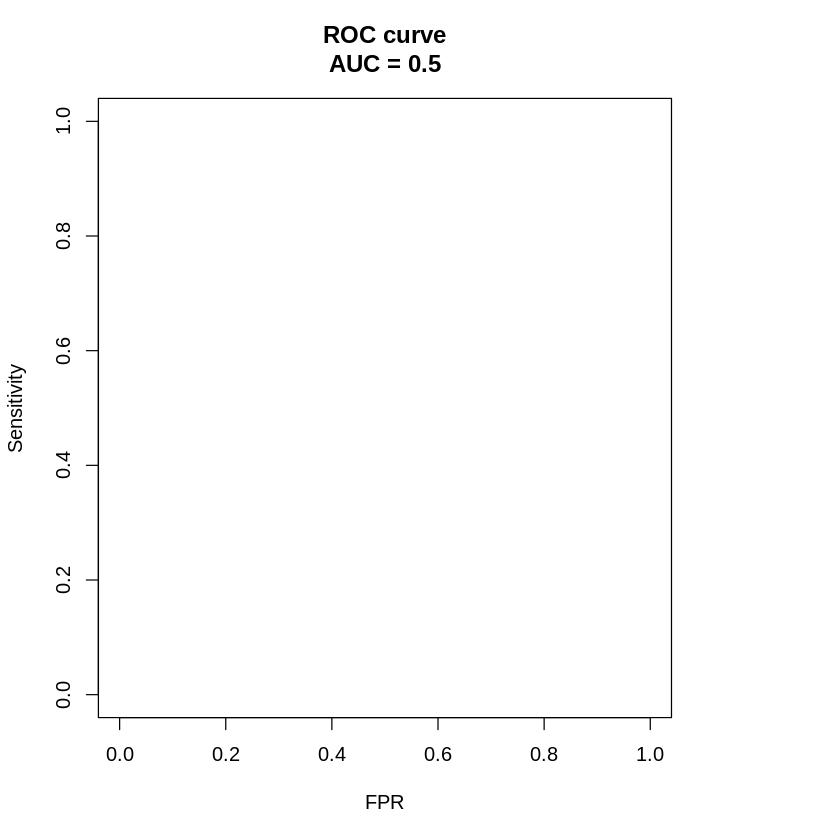

In [ ]:
library("MASS")
library("PRROC")
library(data.table)

data = fread("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat", header = TRUE)
data = as.matrix(na.omit(data))

n = 500
y = data[1:n,15]
X = data[1:n,1:14]

d = ncol(X)

r = 3
N = 100

V<-c(rep(1, 1+d+d*r), rep(1, 1+r+1+r))*diag(1+d+d*r+2+2*r)
SaveResults<- matrix(0,N,1+d+d*r+2+2*r)

# Оптимальное значение prop из текста
lambda <- 2.38
opt_prop <- (lambda^2 / (1+d+d*r+2+2*r)) * V


#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_w_new = 1
lambda_v_new = rep(1, r)

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

Theta_v_matrix = t(matrix(Theta_v, r, d))

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}


#Логарифм функции правдоподобия для Beta
loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
#Логарифм априорного распределения для Theta_H для Beta
log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
#Логарифм априорного распределения для Theta для Beta
log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

#Логарифм апостериорного распределения для Beta
logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

for(i in 1:N){
  Beta_new <- mvrnorm(1, Beta, opt_prop) # надо правильно подбирать матрицу V

  Beta_Theta_0 = Beta_new[1]
  Beta_Theta_w = Beta_new[2:(d+1)]
  Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
  Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

  Beta_mu_w_new = Beta_new[1+d+d*r+1]
  Beta_mu_v_new = Beta_new[(1+d+d*r+2):(1+d+d*r+1+r)]

  Beta_lambda_w_new = Beta_new[1+d+d*r+2+r]
  Beta_lambda_v_new = Beta_new[(1+d+d*r+3+r):(1+d+d*r+2+2*r)]

  if (Beta_lambda_w_new < 0 | any(Beta_lambda_v_new < rep(0,r))){
    SaveResults[i,] <- Beta
    next
  }

  #Логарифм функции правдоподобия для Beta_new
  loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
  #Логарифм априорного распределения для Theta_H для Beta_new
  log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
  #Логарифм априорного распределения для Theta для Beta_new
  log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

  #Логарифм апостериорного распределения для Beta_new
  logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

  alpha = logpost_Beta_new - logpost_Beta

  if(log(runif(1)) <  alpha)
  {
    Beta <- Beta_new
    logpost_Beta <- logpost_Beta_new
  }
    SaveResults[i,] <- Beta
}
b_1 <- colMeans(SaveResults)
V = matrix(b_1[(d+2):(d+1+d*r)],d,r,byrow=TRUE)

X1 = data[501:689,1:14]
y1 = data[501:689,15]

D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(b_1[1] + X1 %*%b_1[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)

**Banknote Dataset**

[1] 0.8823435

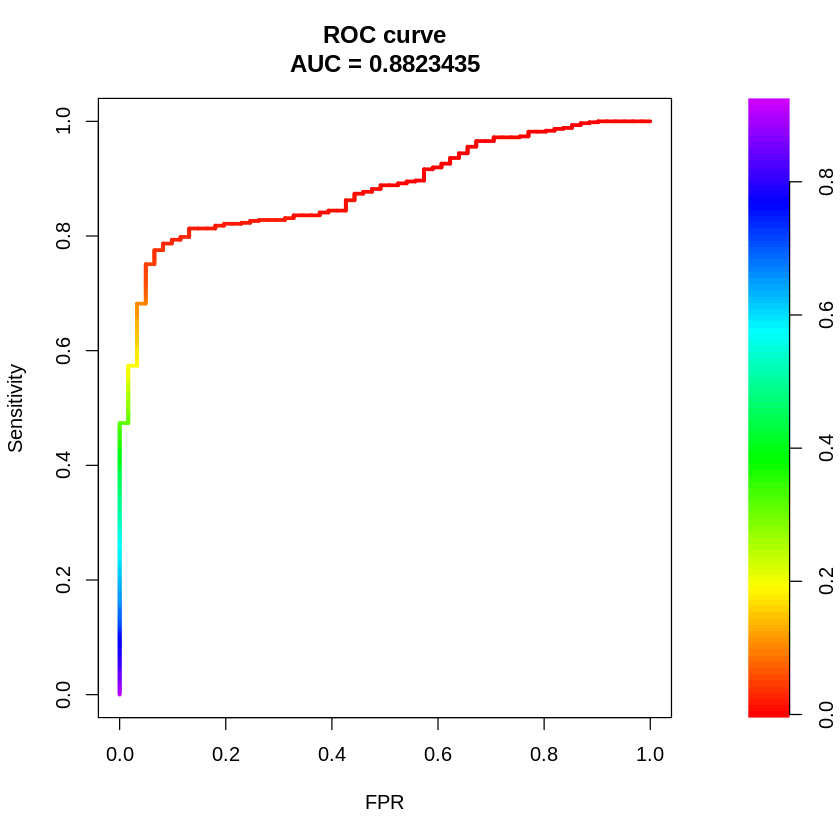

In [ ]:
library("MASS")
library("PRROC")
library(data.table)

data <- fread("http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt", header = TRUE)
data = as.matrix(data)

X = data[1:700,1:4]
y = data[1:700,5]

d = ncol(X)
n=700
r = 2
N = 100

V<-c(rep(1, 1+d+d*r), rep(1, 1+r+1+r))*diag(1+d+d*r+2+2*r)
SaveResults<- matrix(0,N,1+d+d*r+2+2*r)

# Оптимальное значение prop из текста
lambda <- 0.5       #2.38
opt_prop <- (lambda^2 / (1+d+d*r+2+2*r)) * V

#Тета_0 - фиксированные параметры
mu_0 = 0
mu_w_0 = 2
lambda_w_0 = 3
gamma_0 = 1
alpha_lambda = 1
beta_lambda = 1

mu_w_new = 0
mu_v_new = rep(0, r)
lambda_w_new = 1
lambda_v_new = rep(1, r)

Theta_0 = 0
Theta_w = rep(0, d)
Theta_v = rep(0, d*r)
Beta = c(Theta_0, Theta_w, Theta_v, lambda_w_new, mu_w_new, lambda_v_new, mu_v_new)

Theta_v_matrix = t(matrix(Theta_v, r, d))

#Функция: логарифм функции правдоподобия
loglik <- function(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X) {

  loglik_1 = sum(y*(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2)))))
  loglik_0 = sum(log(1+exp(Beta_Theta_0 + X %*% Beta_Theta_w + (0.5 * rowSums((X%*%Beta_v_matrix)^2 - (X^2)%*%(Beta_v_matrix^2))))))
  loglik = loglik_1 - loglik_0
  return(loglik)
}

#Функция: логарифм априорного распределения для Theta_H
log_theta_H = function(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new) {

  log_lambda_w = dgamma(Beta_lambda_w_new, shape = alpha_lambda,rate = beta_lambda, log = TRUE)
  log_mu_w = dnorm(Beta_mu_w_new, mu_0, sqrt(1/(gamma_0*Beta_lambda_w_new)), log = TRUE)
  log_lambda_v = sum(dgamma(Beta_lambda_v_new , shape = alpha_lambda,rate = beta_lambda, log = TRUE))
  log_mu_v = sum(dnorm(Beta_mu_v_new, mu_0, sqrt(1/(gamma_0 * Beta_lambda_v_new)), log = TRUE))

  log_theta_H = log_lambda_w + log_mu_w + log_lambda_v + log_mu_v
  return(log_theta_H)
}

#Функция: логарифм априорного распределения для Theta
log_theta = function(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new){

  log_theta_0 = dnorm(Beta_Theta_0, mu_w_0, sqrt(1/lambda_w_0), log = TRUE)
  log_theta_w = sum(dnorm(Beta_Theta_w, Beta_mu_w_new, sqrt(1/Beta_lambda_w_new), log = TRUE))
  log_theta_v = sum(dnorm(Beta_v_matrix, Beta_mu_v_new, sqrt(1/Beta_lambda_v_new), log = TRUE))

  log_theta = log_theta_0 + log_theta_w + log_theta_v
  return(log_theta)
}

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}


#Логарифм функции правдоподобия для Beta
loglik_Beta = loglik(Theta_0, Theta_w, Theta_v_matrix, y, X)
#Логарифм априорного распределения для Theta_H для Beta
log_theta_H_Beta = log_theta_H(lambda_w_new, alpha_lambda, beta_lambda, mu_w_new, mu_0, gamma_0, lambda_v_new, mu_v_new)
#Логарифм априорного распределения для Theta для Beta
log_theta_Beta = log_theta(Theta_0, mu_w_0, lambda_w_0, Theta_w, mu_w_new, lambda_w_new, Theta_v_matrix, mu_v_new, lambda_v_new)

#Логарифм апостериорного распределения для Beta
logpost_Beta = loglik_Beta + log_theta_H_Beta + log_theta_Beta

for(i in 1:N){
  Beta_new <- mvrnorm(1, Beta, opt_prop) # надо правильно подбирать матрицу V

  Beta_Theta_0 = Beta_new[1]
  Beta_Theta_w = Beta_new[2:(d+1)]
  Beta_Theta_v = Beta_new[(d+2):(d+1+d*r)]
  Beta_v_matrix = t(matrix(Beta_Theta_v, r, d))

  Beta_mu_w_new = Beta_new[1+d+d*r+1]
  Beta_mu_v_new = Beta_new[(1+d+d*r+2):(1+d+d*r+1+r)]

  Beta_lambda_w_new = Beta_new[1+d+d*r+2+r]
  Beta_lambda_v_new = Beta_new[(1+d+d*r+3+r):(1+d+d*r+2+2*r)]

  if (Beta_lambda_w_new < 0 | any(Beta_lambda_v_new < rep(0,r))){
    SaveResults[i,] <- Beta
    next
  }

  #Логарифм функции правдоподобия для Beta_new
  loglik_Beta_new = loglik(Beta_Theta_0, Beta_Theta_w, Beta_v_matrix, y, X)
  #Логарифм априорного распределения для Theta_H для Beta_new
  log_theta_H_Beta_new = log_theta_H(Beta_lambda_w_new, alpha_lambda, beta_lambda, Beta_mu_w_new, mu_0, gamma_0, Beta_lambda_v_new, Beta_mu_v_new)
  #Логарифм априорного распределения для Theta для Beta_new
  log_theta_Beta_new = log_theta(Beta_Theta_0, mu_w_0, lambda_w_0, Beta_Theta_w, Beta_mu_w_new, Beta_lambda_w_new, Beta_v_matrix, Beta_mu_v_new, Beta_lambda_v_new)

  #Логарифм апостериорного распределения для Beta_new
  logpost_Beta_new = loglik_Beta_new + log_theta_H_Beta_new + log_theta_Beta_new

  alpha = logpost_Beta_new - logpost_Beta

  if(log(runif(1)) <  alpha)
  {
    Beta <- Beta_new
    logpost_Beta <- logpost_Beta_new
  }
    SaveResults[i,] <- Beta
}
b_1 <- colMeans(SaveResults)
V = matrix(b_1[(d+2):(d+1+d*r)],d,r,byrow=TRUE)

X1 = data[701:1371,1:4]
y1 = data[701:1371,5]

D = 0.5 * rowSums((X1%*%V)^2 - (X1^2)%*%(V^2))
prob = 1 /(1 + exp(-(b_1[1] + X1 %*%b_1[2:(d+1)] + D)))

auroc(prob,y1)
PRROC_obj <- roc.curve(scores.class0 = prob, weights.class0=y1,
                       curve=TRUE)
plot(PRROC_obj)